# COGS 109 Final Project

### Chen Meng, c5meng@ucsd.edu
### Fengyuan Heying, fheying@ucsd.edu
### [Your name] 

In [34]:
# Import libraries
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Background

dataset: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

The Communities and Crime dataset contains socioeconomic data that are potential factors of crime. This dataset was curated by combining socio-economic data from the 1990 Census, law enforcement data from the 1990 Law Enforcement Management and Admin Stats survey, and crime data from the 1995 FBI UCR.

__Variable Outlook:__

predictive variables : 125

non-predictive variables : 4

potential goal/response variables : 18

Total: 147 Attributes

Instances: 2216 Communities 

We would like to explore the impact of education and income on crime which is one of the dominant ideas in crime prevention. We hope to gain insightful information on this critical socioeconomic relationship that could help us and researchers alike to evidence further and identify factors of crime. This will continue to generate important conversation about the potential policies and routes of activism that can supplement crime prevention. 

### Our Research Question: 
Does the lack of a HS education, and household median income predict violent and non-violent crimes?

## Part 1: Acquiring, cleaning, and examining data
__Variables of interest:__

-medIncome - median household income

-PctNotHSGrad - percentage of people 25 and over that are not high school graduates

-ViolentCrimesPerPop - total number of violent crimes per 100K popuation

-nonViolPerPop - total number of non-violent crimes per 100K popuation

In [35]:
# Load headers for the data:
header = open("header.txt", "r").read()
rawLines = [l for l in header.split('--') if len(l) != 0]
colTitles = [l.split(':')[0].strip() for l in rawLines]
print("Total columns:", len(colTitles))

# Initial cleaning of the data
data = pd.read_csv("CommViolPredUnnormalizedData.txt", 
                   names=colTitles, na_values="?") # Missing values are marked with "?", treat as Nan
# Variables of interest:
# medIncome - median household income
# PctNotHSGrad - percentage of people 25 and over that are not high school graduates
# ViolentCrimesPerPop - total number of violent crimes per 100K popuation
# nonViolPerPop - total number of non-violent crimes per 100K popuation
data = data[["communityname","state",
             "medIncome","PctNotHSGrad","ViolentCrimesPerPop","nonViolPerPop"]]
data = data.dropna(0) # drop rows with invalid(nan) values

# Examine the data:
data

Total columns: 147


,communityname,state,medIncome,PctNotHSGrad,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,75122,9.90,41.02,1394.59
1,Marpletownship,PA,47917,13.72,127.56,1955.95
2,Tigardcity,OR,35669,9.09,218.59,6167.51
5,Springfieldcity,MO,21577,23.03,442.95,6867.42
6,Norwoodtown,MA,42805,13.89,226.63,1890.88
...,...,...,...,...,...,...
2210,Mercedcity,CA,24727,30.87,545.75,7356.84
2211,Pinevillecity,LA,20321,27.71,124.10,5824.44
2212,Yucaipacity,CA,27182,26.14,353.83,4654.20
2213,Beevillecity,TX,19899,39.63,691.17,5340.87


## Part 2: Data exploration

### Histogram of Median Household Income per Year

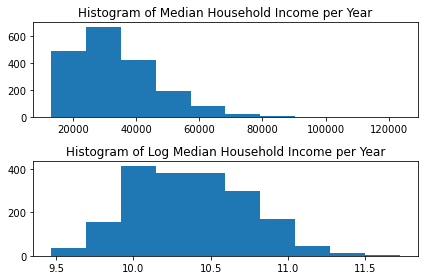

In [36]:
medIncome = data["medIncome"]
logMedIncome = np.log(medIncome.to_numpy())

fig, axs = plt.subplots(2)
axs[0].hist(medIncome)
axs[0].set_title("Histogram of Median Household Income per Year")
axs[1].hist(logMedIncome)
axs[1].set_title("Histogram of Log Median Household Income per Year")
fig.tight_layout()

__Comments:__ medIncome is skewed right, meaning the mean is likely larger than the median. We observe a large range with large variability and incomes close to millions as its outliers. Using log(medIncome), we attempt to normalize the data to minimize its scale. 

### Histogram of Percent of Non Highschool Graduates

Text(0.5, 1.0, 'Histogram of Percent of Non Highschool Graduates')

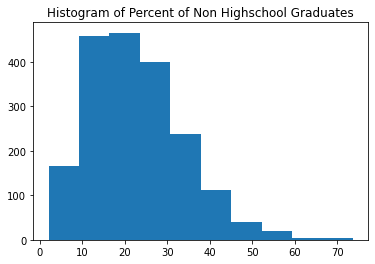

In [37]:
pctNonGrad = data["PctNotHSGrad"]
plt.hist(pctNonGrad)
plt.title("Histogram of Percent of Non Highschool Graduates")

__Comments:__ A large majority of our communities have 20% of their population that are non Highschool graduates. 

The lack of a highschool diploma does not allow for much upward socioeconomic mobility. Could potentially illicit criminal behavior, or is it something more innate? We aim to discuss this further in our analysis with regression that will answer our curiosities on this potential causal effect on crimes.

### Histograms of Violent Crimes and Non Violent Crimes per 100k Population 

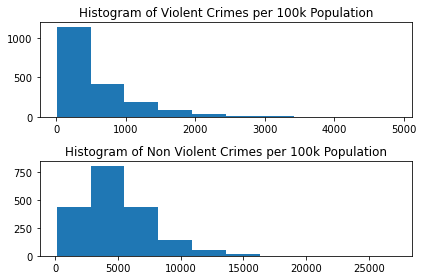

In [38]:
violentCrime = data["ViolentCrimesPerPop"]
nonViolentCrime = data["nonViolPerPop"]
fig, axs = plt.subplots(2)
axs[0].hist(violentCrime)
axs[0].set_title("Histogram of Violent Crimes per 100k Population")
axs[1].hist(nonViolentCrime)
axs[1].set_title("Histogram of Non Violent Crimes per 100k Population")
fig.tight_layout()

__Comments__ Violent Crimes is largely skewed right with the majority of communities with violent crimes less than 1000 per 100k population. However, there exists a small frequency of communities that have 3x the crime rate than the average. 

The amount of Non-Violent Crimes is greater than Violent Crimes, and is more normally distributed. But they both see a max range 3x as much as its average crime rate.

## Methods
## Part 3: Regression Model Construction with Cross-validation

In Depth: Liner Regression and Cross-Validation
1. Select a Model: Violent crimes ~ income
2. Partition dataset into a 80/20 Split for Cross Validation 
3. Use Training data containing 80% Split for initial Regression
4. Create a column array of data for Y (Violent Crimes) and weights w (our coefficient value for median Income) to be filled
5. Augment variable x, our values for Median Income into A
6. Solve for our weights W, aka the coefficients using y = Aw
7. Plug coefficients W into model and plot to visualize result of linear model prediction 
8. Using existing model, use Test data containing 20% to predict linear model
9. Store Test Set SSE to measure model's predictive power

Cross Validation Goal: Return Test Set SSE (Sum Squared Errors)
1. For most predictive power, the Test Set SSE is minimized 
2. Combat data overfitting by observing if Test SSE increases
3. Some models will be tested for overfitting by introducing another variable to the model 

## Part 3a: The Log Dispute: 
The Median Income attribute (medIncome) includes a large range of values with large outliers. We believe by taking the log(medIncome), it could normalize the data and thus decrease the effect of the outliers

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(data[["medIncome", "PctNotHSGrad"]].to_numpy(), data[["ViolentCrimesPerPop","nonViolPerPop"]].to_numpy(), test_size=0.20)


[ 1.19108565e+03 -1.78730896e-02]


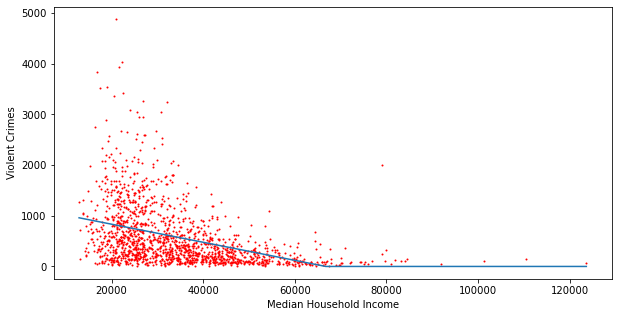

In [40]:
# Model 1: Violent crimes ~ income
#X_train, X_test, Y_train, Y_test = train_test_split(data["medIncome"].to_numpy(), data["ViolentCrimesPerPop"].to_numpy(), test_size=0.20)

X = X_train[:,0]
Y = Y_train[:,0]
#X = data["medIncome"].to_numpy()
#Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w1 = np.linalg.lstsq(A, Y, rcond=None)[0] #ViolentCrimes=w0+w1*medIncome
print(w1)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w1[0] + w1[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Median Household Income")
plt.ylabel("Violent Crimes")

pre1 = w1[0] + w1[1]*X_test[:,0]
SSE1 = sum(np.square(Y_test[:,0] - pre1))


[7555.7548321  -672.68436641]


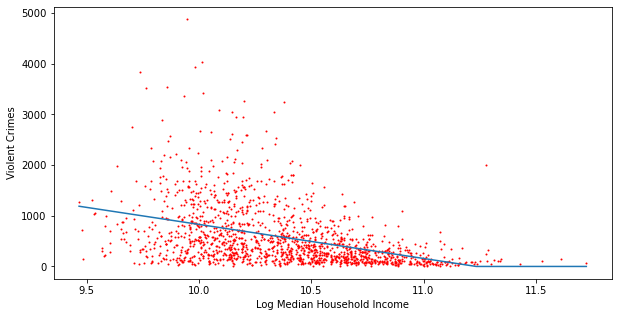

In [41]:
# Model 2: Violent crimes ~ log(income)
#X_train, X_test, Y_train, Y_test = train_test_split(np.log(data["medIncome"].to_numpy()), data["ViolentCrimesPerPop"].to_numpy(), test_size=0.20)

X = np.log(X_train[:,0])
Y = Y_train[:,0]

#X = np.log(data["medIncome"].to_numpy())
#Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w2 = np.linalg.lstsq(A, Y, rcond=None)[0] #ViolentCrimes = min(w0+w1*log(income), 0)
print(w2)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w2[0] + w2[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Log Median Household Income")
plt.ylabel("Violent Crimes")

# SSE comparison
pre2 = w2[0] + w2[1]*np.log(X_test[:,0])
SSE2 = sum(np.square(Y_test[:,0] - pre2))




## SSE of model 1 and model 2

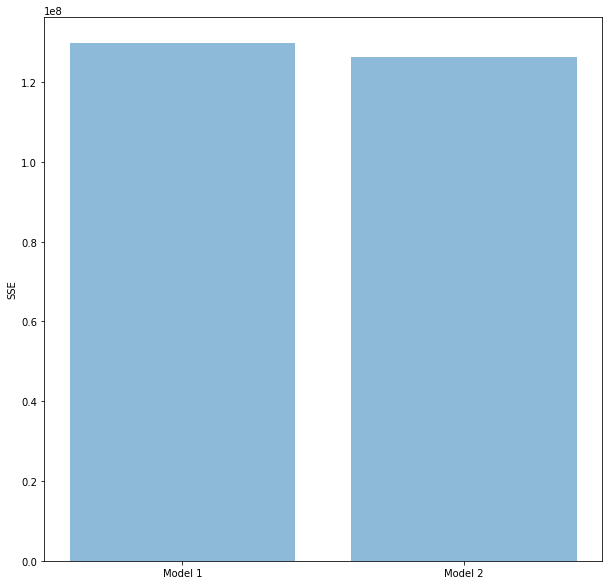

In [42]:
SSEst = ('Model 1', 'Model 2')
SSEV = [SSE1,SSE2]
plt.figure(figsize=(10, 10))
yght = [0,1]
plt.bar(yght, SSEV, align='center', alpha=0.5)
plt.xticks(yght,SSEst)
plt.ylabel("SSE")
plt.show()

### SSE of model 1 and model 2 excluding and including log()
We cannot draw a concrete conclusion that normalizing our data with log() produces a significantly better SSE, therefore we will maintain a medIncome attribute from this point on in our analysis. 

## Part 3b: Violent Crimes Models (1-4) vs. Non-Violent Crimes Models (5-7)

The coefficients and SSE significance of the regressions will allow us to observe the effect of Education and Income on different, but likely correlated predictors of Violent and Non-Violent Crimes.

### Issue of Overfitting Data:

Our goal is to combat overfitting by testing univariate, then multivariate regression models on each of our selected predictors income (medIncome) and education (pctNonGrad). We will introduce each term or interaction in a new model to compare the SSEs of the previous models to ensure best predictive power.

[ 5.14501529 25.5587386 ]


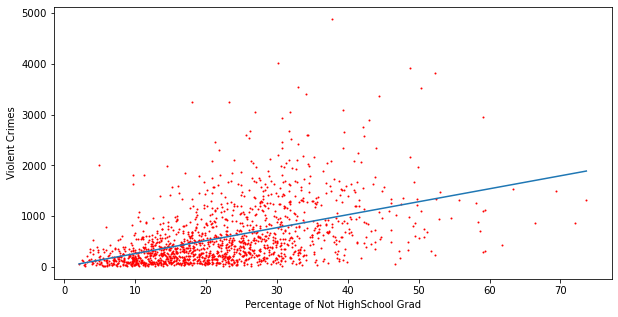

In [43]:
# Model 3: Violent crimes ~ Education
#X_train, X_test, Y_train, Y_test = train_test_split(data["PctNotHSGrad"].to_numpy(), data["ViolentCrimesPerPop"].to_numpy(), test_size=0.20)

X = X_train[:,1]
Y = Y_train[:,0]


#X = data["PctNotHSGrad"].to_numpy()
#Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1)
w3 = np.linalg.lstsq(A, Y, rcond=None)[0] #violentcrimes = w0+w1*education
print(w3)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w3[0] + w3[1]*x).clip(min=0))(x_values) 

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Percentage of Not HighSchool Grad")
plt.ylabel("Violent Crimes")

pre3 = w3[0] + w3[1]*X_test[:,1]
SSE3 = sum(np.square(Y_test[:,0] - pre3))

In [44]:
# Model 4: Violent crimes ~ Income, Education
#X_train, X_test, Y_train, Y_test = train_test_split(data[["medIncome", "PctNotHSGrad"]].to_numpy(), data["ViolentCrimesPerPop"].to_numpy(), test_size=0.20)

X = X_train
Y = Y_train[:,0]



#X = data[["medIncome", "PctNotHSGrad"]].to_numpy()
#Y = data["ViolentCrimesPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
product = np.array([X[i,0]*X[i,1] for i in range(X.shape[0])])
A = np.append(ones, X, axis=1)
A = np.append(A, product.reshape(n,1), axis=1)
w4 = np.linalg.lstsq(A, Y, rcond=None)[0] #ViolentCrimes=w0+w1*medIncome+w2*education+w3*income*education
print(w4)
pre4 = w4[0] + w4[1]*X_test[:,0]+w4[2]*X_test[:,1]+w4[3]*X_test[:,0]*X_test[:,1]
SSE4 = sum(np.square(Y_test[:,0] - pre4))

[ 2.75554447e+02 -3.08675268e-03  2.82531670e+01 -3.36122755e-04]


### Non-Violent Crimes Models

[ 8.20497993e+03 -9.61097266e-02]


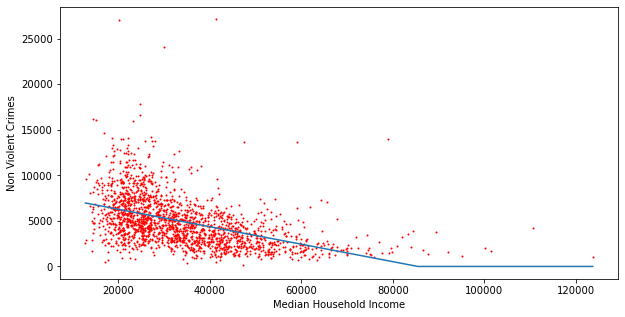

In [45]:
# Model 5: Non Violent crimes ~ income
#X_train, X_test, Y_train, Y_test = train_test_split(data["medIncome"].to_numpy(), data["nonViolPerPop"].to_numpy(), test_size=0.20)

X = X_train[:,0]
Y = Y_train[:,1]

X = data["medIncome"].to_numpy()
Y = data["nonViolPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w5 = np.linalg.lstsq(A, Y, rcond=None)[0] #NonViolentCrimes=w0+w1*medIncome
print(w5)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w5[0] + w5[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Median Household Income")
plt.ylabel("Non Violent Crimes")



pre5 = w5[0] + w5[1]*X_test[:,0]
SSE5 = sum(np.square(Y_test[:,1] - pre5))

[2919.79302837   88.51277849]


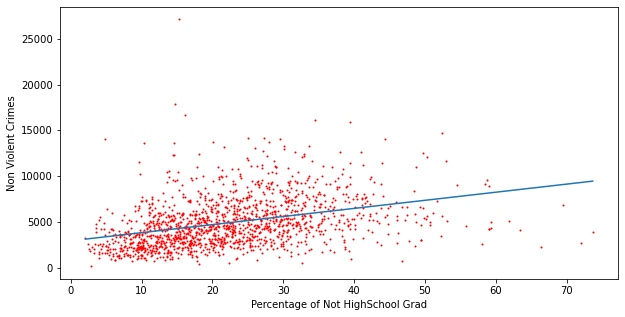

In [46]:
# Model 6: Non Violent crimes ~ education

#X_train, X_test, Y_train, Y_test = train_test_split(data["PctNotHSGrad"].to_numpy(), data["nonViolPerPop"].to_numpy(), test_size=0.20)

X = X_train[:,1]
Y = Y_train[:,1]

#X = data["PctNotHSGrad"].to_numpy()
#Y = data["nonViolPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
A = np.append(ones, X.reshape(n,1), axis=1) 
w6 = np.linalg.lstsq(A, Y, rcond=None)[0] #NonViolentCrimes=w0+w1*education
print(w6)

# Generate values for plotting the regression model
x_values = np.linspace(np.min(X), np.max(X), 2000)
model = (lambda x: (w6[0] + w6[1]*x).clip(min=0))(x_values)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1, color='red')
plt.plot(x_values, model)
plt.xlabel("Percentage of Not HighSchool Grad")
plt.ylabel("Non Violent Crimes")

pre6 = w6[0] + w6[1]*X_test[:,1]
SSE6 = sum(np.square(Y_test[:,1] - pre6))

In [47]:
# Model 7: Non Violent crimes ~ Income, Education, Income*Education
#X_train, X_test, Y_train, Y_test = train_test_split(data[["medIncome", "PctNotHSGrad"]].to_numpy(), data["nonViolPerPop"].to_numpy(), test_size=0.20)

X = X_train
Y = Y_train[:,1]


#X = data[["medIncome", "PctNotHSGrad"]].to_numpy()
#Y = data["nonViolPerPop"].to_numpy()
n = len(Y)
ones = np.ones(n, dtype=int).reshape(n,1)
product = np.array([X[i,0]*X[i,1] for i in range(X.shape[0])])
A = np.append(ones, X, axis=1)
A = np.append(A, product.reshape(n,1), axis=1)
w7 = np.linalg.lstsq(A, Y, rcond=None)[0] #NonViolentCrimes=w0+w1*medIncome+w2*education+w3*income*education
print(w7)

pre7 = w7[0] + w7[1]*X_test[:,0]+w7[2]*X_test[:,1]+w7[3]*X_test[:,0]*X_test[:,1]
SSE7 = sum(np.square(Y_test[:,1] - pre7))

[ 6.63206748e+03 -5.47746063e-02  8.46408921e+01 -2.61203231e-03]


## Part 4: Model Comparison

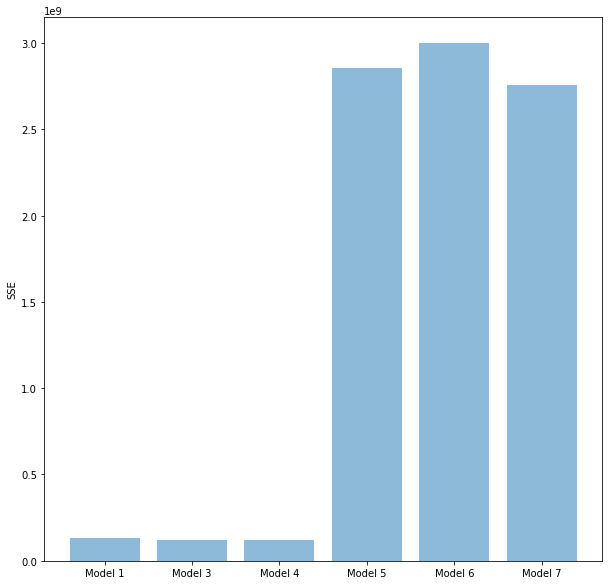

In [48]:
SSEst = ('Model 1', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7')
SSEV = [SSE1,SSE3,SSE4,SSE5,SSE6,SSE7]
plt.figure(figsize=(10, 10))
yght = [0,1,2,3,4,5]
plt.bar(yght, SSEV, align='center', alpha=0.5)
plt.xticks(yght,SSEst)
plt.ylabel("SSE")
plt.show()

## Part 5: Analysis and Conclusion

#### Recap: 
Our exploratory analysis highlighted a high variance median income, and an average of 20% of a population with no high school diplomas. After an attempt to normalize median income, we decided to push Model 1 without log() in favor over model 2 with log() because the SSE was not significantly different enough to suggest favorability over one another. 

After the Log Dispute, our remaining analysis includes Models 1-4 as Violent Crimes Predictors, and Models 5-7 as Non-Violent Crimes. We combat overfitting within each predictor by introducing new terms in each model. We utilize SSEs from Cross Validation to make our comparisons. 

#### Results: 
Our attributes are stronger predictors for Violent Crime Models since they collectively outperform the Non-Violent Crime Models SSEs for the same attributes. This tells us that Education and Income are not as predictive of Non-Violent Crimes than Violent Crimes. 
For our models with Violent Crimes, the SSEs between each model are not significantly different, thus we cannot make any valid conclusions on whether one attribute is better than the other. The models with Non-Violent Crimes are similarly inconclusive. We suspect from these results that Income and Education are likely dependent and strongly correlated with each other.

#### Discussion
Our research question asked whether or not the lack of a HS education and household median income could predict violent and non-violent crimes. From our analysis we were able to draw the conclusion by comparing SSEs that the lack of education and income is a solid predictor for violent crimes, but not for non-violent crimes. Education and Income may not have been the best to predict non-violent crimes because there the frequency of non-violent crimes is much higher, thus less sensitive to our attributes. 

Our analysis technique was fitting, but can be improved with parameter selection. A preliminary stepwise regression would give us the significance of each attribute towards a predictor. Since "The per capita nonviolent crime variable was calculated using the sum of crime variables considered non-violent crimes in the United States: burglaries, larcenies, auto thefts and arsons," We suggest further research into the classification of non-violent crimes to include white-collar crimes, cybercrimes, and fraud. These non-violent crimes may neccesitate higher ability and knowledge, and a level of education to commit.
